In [117]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [118]:
import numpy as np
import pandas as pd

In [119]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [120]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [128]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [129]:
conn = engine.connect()

In [130]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [131]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [132]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [133]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [134]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date1 = str(latest_date)[2:-3]
print(f'{latest_date1} vs {latest_date}')


2017-08-23 vs ('2017-08-23',)


In [135]:
## Used three different way to generate the date (two above and this one)
latest_date = session.query(Measurement.date).filter(func.strftime("%Y-%m-%d", Measurement.date)).order_by(Measurement.date.desc()).first()
latest = latest_date[0]
print(latest)

2017-08-23


In [136]:
from sqlalchemy import Table, Column, MetaData, DateTime
from datetime import datetime, timedelta

In [137]:
# Calculate the date 1 year ago from the last data point in the database

start_date = str(eval(latest_date1[0:4])-1) + latest_date1[4:]
print(start_date)


2016-08-23


In [138]:
# Perform a query to retrieve the data and precipitation scores
Precip_12m = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= latest).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(Precip_12m)
precip_df1 = precip_df.rename(columns={'prcp':'precipitation'})
precip_indexed_df = precip_df1.set_index("date")
precip_indexed_df.head()

# Use Pandas Plotting with Matplotlib to plot the data


,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


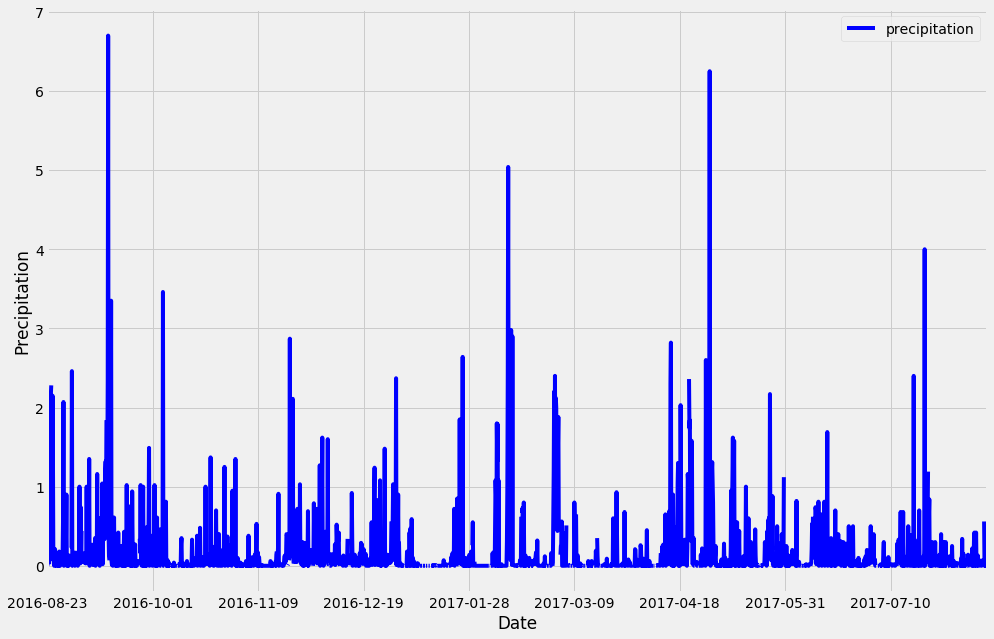

In [139]:
precip_indexed_df.plot(color="blue", figsize=(15,10) )
plt.legend(loc=1)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend(loc=0)
plt.show()

In [140]:
# calcualte the summary statistics precipitation data
precip_indexed_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [141]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(func.count(Station.station))
station_count = stations[0]
#station_count

In [142]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
observations = session.query(Measurement.station, func.count(Measurement.tobs))\
             .group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())

for station in observations:
    print(station)
    pass

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [143]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),\
                      func.avg(Measurement.tobs)).filter(Measurement.station == observations[0][0])
                      
print(f'Busiest station stats (Low, High, and Average) {list(stats)}')

Busiest station stats (Low, High, and Average) [(54.0, 85.0, 71.66378066378067)]


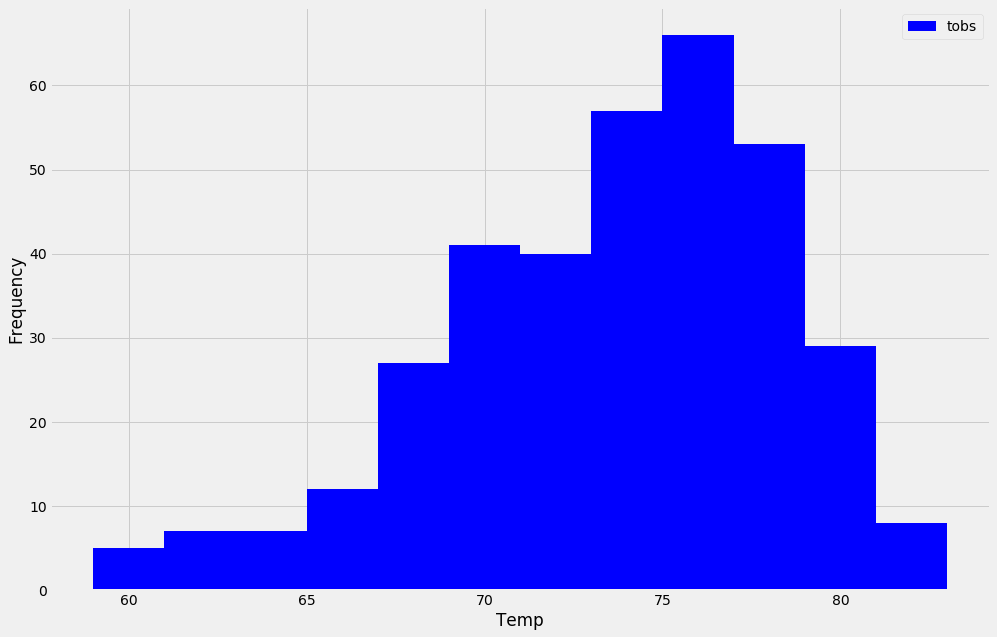

In [144]:
# Extract station with the highest # of temperature
# Pull 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.tobs)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= latest_date1)\
.filter(Measurement.station == observations[0][0])\

tobs_list = []
for tob in tobs:
    tobs_list.append(tob[0])
    
fig = plt.figure(figsize=(15,10))
plt.hist(tobs_list, bins=12 , label='tobs', color ="blue")
plt.xlabel("Temp")
plt.ylabel("Frequency")
plt.legend(loc=0)
plt.show()


## Temperature Analysis II 
### Optional Recommended Analyis

In [145]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [146]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Arrival_date = ('2017,04,09')
Departure_date = ('2017,04,16')

def calc_temps(Arrival_date, Departure_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        Arrival_date (string): A date string in the format %Y-%m-%d
        Departure_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= Arrival_date).filter(Measurement.date <= Departure_date).all()

# function usage example
print(calc_temps('2017-04-09', '2017-04-16'))


[(67.0, 74.0, 82.0)]


In [147]:
Arrival_date = '2017-04-09'
Departure_date = '2017-04-16'
Trip_1 = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.date >= Arrival_date).filter(Measurement.date <= Departure_date).all()

# having problems with "None" values". showing dataframe to confirm correct info for dates
trip_4cast = pd.DataFrame(Trip_1, columns=['Date', 'Tobs'])
trip_4cast.head(8)

,Date,Tobs
0,2017-04-09,72.0
1,2017-04-10,75.0
2,2017-04-11,79.0
3,2017-04-12,78.0
4,2017-04-13,77.0
5,2017-04-14,75.0
6,2017-04-15,73.0
7,2017-04-16,74.0


In [148]:
last_year_temp_analysis = calc_temps(Arrival_date, Departure_date)

tmin = last_year_temp_analysis[0][0]
tmax = last_year_temp_analysis[0][1]
tavg = last_year_temp_analysis[0][2]

print(last_year_temp_analysis)

[(67.0, 74.0, 82.0)]


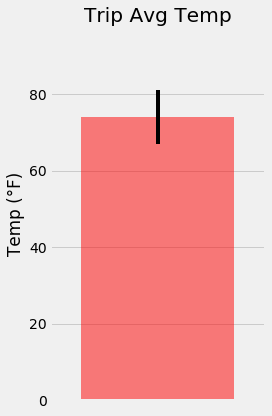

In [149]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(1.5))

bar= ax.bar(1, tmax, yerr=(tmax-tmin),alpha=0.5, color="red")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel = "Temp (°F)")
ax.margins(.2,.2)
fig.tight_layout()

plt.show()


In [150]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]